#### Base Settings

##### Library

In [1]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import string
from collections import Counter
import random

# shikit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow as keras
from keras import layers, Input, Sequential, Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, \
                                    TextVectorization
import tensorflow_datasets as tfds

##### Parmas

In [2]:
RAND_SEED = 83
random.seed(RAND_SEED)

NUM_TEXT_DATA       = 1         #📌 사용할 데이터 비율
MAX_LENGTH          = 20            #📌 문장 길이
BATCH_SIZE          = 64
BUFFER_SIZE         = 20000
NUM_LAYERS          = 2
D_MODEL             = 512
NUM_HEADS           = 4
DFF                 = 256
DROPOUT             = 0.1
VOCAB_SIZE          = 10000
EPOCHS              = 10

### Data handling

In [3]:
def collect_json_file(path):
    """
    폴더의 json파일을 모두 불러와 리스트로 반환하는 함수
    """
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [4]:
def parsing_corpus(js):
    Q1_list = [js[x]["talk"]["content"]["HS01"] for x in range(len(js))]
    Q2_list = [js[x]["talk"]["content"]["HS02"] for x in range(len(js))]
    Q3_list = [js[x]["talk"]["content"]["HS03"] for x in range(len(js))]
    A1_list = [js[x]["talk"]["content"]["SS01"] for x in range(len(js))]
    A2_list = [js[x]["talk"]["content"]["SS02"] for x in range(len(js))]
    A3_list = [js[x]["talk"]["content"]["SS03"] for x in range(len(js))]

    df_qa = pd.DataFrame({"Q1":Q1_list,"A1":A1_list,"Q2":Q2_list,"A2":A2_list,"Q3":Q3_list,"A3":A3_list})

    return df_qa

#### 감성 대화 말뭉치

- [감성 대화 말뭉치](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86)



2020년/10,000문장 (음성), 27만문장 (코퍼스)



In [7]:
# 구글드라이브에서 데이터파일(.json) 불러와서 폴더에 저장

## 데이터파일 불러올 URL
url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing",
            "https://drive.google.com/file/d/1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c/view?usp=sharing"]

for idx, val in enumerate(url_list):
    data_url = val
    file_name = "donwload.zip"
    unzip_path = "data/emotion/"

    # 데이터 다운로드
    file_id = "https://drive.google.com/uc?id=" + data_url.split('/')[-2]
    gdown.download(file_id, file_name)

    # 압축풀기
    files = zf.ZipFile(file_name)
    files.extractall(unzip_path)
    files.close()

# 데이터파일(.json)
json_list = collect_json_file(unzip_path)
print(f"\n데이터파일 개수 : {len(json_list)}개")

with tqdm(total=len(json_list)) as pbar:
    df_concat = pd.DataFrame()
    for idx, val in enumerate(json_list):
        with open(unzip_path+json_list[idx]) as f:
            js = json.loads(f.read())
            df_qa = parsing_corpus(js)
            print(f"{idx+1}번째 파일의 크기: {df_qa.shape}")
            df_concat = pd.concat([df_concat,df_qa])
        pbar.update()

print(f"\n데이터파일의 크기(shape) : {df_concat.shape}")

Downloading...
From: https://drive.google.com/uc?id=1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg
To: /content/donwload.zip
100%|██████████| 8.30M/8.30M [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c
To: /content/donwload.zip
100%|██████████| 993k/993k [00:00<00:00, 123MB/s]



데이터파일 개수 : 2개


 50%|█████     | 1/2 [00:01<00:01,  1.42s/it]

1번째 파일의 크기: (51628, 6)


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

2번째 파일의 크기: (6640, 6)

데이터파일의 크기(shape) : (58268, 6)


In [8]:
# # 작업폴더에 직접 json 파일 업로드

# json_list = ["감성대화말뭉치(최종데이터)_Training.json", "감성대화말뭉치(최종데이터)_Validation.json"]
# with tqdm(total=len(json_list)) as pbar:
#     df_concat = pd.DataFrame()
#     for idx, val in enumerate(json_list):
#         with open(json_list[idx]) as f:
#             js = json.loads(f.read())
#             df_qa = parsing_corpus(js)
#             print(f"{idx+1}번째 파일의 크기: {df_qa.shape}")
#             df_concat = pd.concat([df_concat,df_qa])
#         pbar.update()

# print(f"\n데이터파일의 크기(shape) : {df_concat.shape}")

In [9]:
print(f"질문1 : {df_concat.iloc[0,0]}")
print(f"답변1 : {df_concat.iloc[0,1]}")
print(f"질문2 : {df_concat.iloc[0,2]}")
print(f"답변2 : {df_concat.iloc[0,3]}")
print(f"질문3 : {df_concat.iloc[0,4]}")
print(f"답변3 : {df_concat.iloc[0,5]}")

질문1 : 일은 왜 해도 해도 끝이 없을까? 화가 난다.
답변1 : 많이 힘드시겠어요. 주위에 의논할 상대가 있나요?
질문2 : 그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.
답변2 : 혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요. 
질문3 : 
답변3 : 


In [10]:
df_concat.tail()

,Q1,A1,Q2,A2,Q3,A3
6635,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...,같은 시기에 결혼하는 친구들끼리 상황이 다르다 보니 마음이 좋지 않으시겠어요.,우리만 뒤처지는 것 같고. 그래도 열심히 살다 보면 우리도 집을 살 수 있겠지?,우리 부부만 뒤처지는 것 같아 속상하지만 열심히 살다 보면 집을 살 수 있다고 믿으...,,
6636,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아.,기분이 좋지 않으신 이유를 알고 계시나요?,나도 결혼했지만 아이도 생기지 않고 그 정도로 행복하지 않거든. 친구보다 못사는 것...,친구분과 비교하게 되어 기분이 좋지 않으셨군요. 어떻게 하면 기분이 풀릴 수 있을까요?,,
6637,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.,돈을 모으는 것으로 자괴감이 드시는군요.,요새 집값이 너무 올라서 한숨만 나와.,집값이 올라 한숨만 나오시는군요.,,
6638,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,먼저 결혼한 친구가 부럽군요.,맞아. 그 친구와 비교하게 되니 자존감이 낮아지는 기분이야.,비교로 자존감이 낮아지는군요.,,
6639,친구들 모두 결혼하고 나만 혼자 남아서 쓸쓸하네.,혼자 남아 외로움을 느끼는 것 같군요.,맞아. 하지만 그렇다고 아무나하고 결혼할 수도 없잖아.,이럴 때 기분을 나아지게 해 줄 만한 방법이 있을까요?,,


In [11]:
# # 모든턴 사용
# df_1 = df_concat[["Q1","A1"]]
# df_2 = df_concat[["Q2","A2"]]
# df_3 = df_concat[["Q3","A3"]]

# df_1.columns = ["Q1", "A1"]
# df_2.columns = ["Q1", "A1"]
# df_3.columns = ["Q1", "A1"]

# df = pd.DataFrame()
# df = pd.concat([df,df_1])
# df = pd.concat([df,df_2])
# df = pd.concat([df,df_3])


# df.reset_index(drop=True, inplace=True)
# filt = df["A1"].str.len() < 3
# df.drop(index=df[filt].index, inplace=True)
# print(df.shape)
# df.sample(5)

In [12]:
# 1턴만 사용
df = df_concat[["Q1","A1"]].copy()
print(df.shape)
df.sample(8, random_state=RAND_SEED)

(58268, 2)


,Q1,A1
16263,인기 많은 여자 친구가 언젠가 다른 사람에게 가버리는 건 아닌지 불안해.,여자 친구가 언젠가 다른 사람에게 가버리는 건 아닌지 불안하시군요.
1037,요즘은 자면서도 죽기만을 바라며 잠이 들어.,자다가 죽기만을 바라며 잠이 드시다니. 힘드시고 슬프시겠어요.
23448,좀 더 젊었을 때 저축을 해두지 않은 게 후회가 돼.,저축을 하지 못 한 게 후회되나 보군요.
35391,펀드매니저의 도움으로 자산을 안전하게 투자하였어. 그래서 마음이 편해졌어.,자산을 안전하게 투자해서 마음이 편해지셨군요.
41045,난 이제 아무것도 아니야 다들 날 무시하는 거 같아.,왜 그런 생각을 갑자기 하시는 거예요?
1237,내가 잘못한 것도 없는데 딸이 나랑 얘기하는 것조차 싫어해.,조금 더 자세히 얘기해주시겠어요?
29852,시험 공부좀 할껄 지금까지 너무 놀기만 했나봐.,시험 공부를 안 하셨나요? 조금 더 자세히 말씀해주세요.
13417,괴롭힘 당하는 친구가 도와달라고 했는데 나도 괴롭힘 당할까 봐 멈칫했어. 친구가 상...,주저하는 모습에 친구가 상처 받았을까 봐 걱정되는군요.


In [13]:
NUM_TEXT_DATA       = int(df.shape[0] * NUM_TEXT_DATA)      # ✅ 사용 할 데이터 비율

qna_data = df.sample(NUM_TEXT_DATA, random_state=RAND_SEED).copy()
print(qna_data.shape)
qna_data.head(8)

(58268, 2)


,Q1,A1
16263,인기 많은 여자 친구가 언젠가 다른 사람에게 가버리는 건 아닌지 불안해.,여자 친구가 언젠가 다른 사람에게 가버리는 건 아닌지 불안하시군요.
1037,요즘은 자면서도 죽기만을 바라며 잠이 들어.,자다가 죽기만을 바라며 잠이 드시다니. 힘드시고 슬프시겠어요.
23448,좀 더 젊었을 때 저축을 해두지 않은 게 후회가 돼.,저축을 하지 못 한 게 후회되나 보군요.
35391,펀드매니저의 도움으로 자산을 안전하게 투자하였어. 그래서 마음이 편해졌어.,자산을 안전하게 투자해서 마음이 편해지셨군요.
41045,난 이제 아무것도 아니야 다들 날 무시하는 거 같아.,왜 그런 생각을 갑자기 하시는 거예요?
1237,내가 잘못한 것도 없는데 딸이 나랑 얘기하는 것조차 싫어해.,조금 더 자세히 얘기해주시겠어요?
29852,시험 공부좀 할껄 지금까지 너무 놀기만 했나봐.,시험 공부를 안 하셨나요? 조금 더 자세히 말씀해주세요.
13417,괴롭힘 당하는 친구가 도와달라고 했는데 나도 괴롭힘 당할까 봐 멈칫했어. 친구가 상...,주저하는 모습에 친구가 상처 받았을까 봐 걱정되는군요.


#### 데이터 분할

In [14]:
qna_data = qna_data.sample(frac=1, random_state=RAND_SEED).reset_index(drop=True)   # 데이터 섞기
num_val_samples = int(0.2 * len(qna_data))                                          # 총 데이터의 20%
num_train_samples = len(qna_data) - num_val_samples                                 # train, val 비율 = 8:2
train_data = qna_data[:num_train_samples]
val_data = qna_data[num_train_samples :]

print(f"전체 데이터셋 개수: {len(qna_data)}")
print(f"학습 데이터셋 개수: {len(train_data)}")
print(f"검증 데이터셋 개수: {len(val_data)}")

전체 데이터셋 개수: 58268
학습 데이터셋 개수: 46615
검증 데이터셋 개수: 11653


#### "이연준 챗봇" 학습 데이터

In [15]:
data = {"Q1" : [
                "너는 누구니?",
                "챗봇의 이름이 뭐야?",
                "당신은 누구십니까?",
                "당신의 이름은 무엇입니까?",
                "챗봇 이름이 뭐야?",
                "너는 뭐야?",
                "너는 자신을 무엇이라고 생각하니?",
                "너는 이름이 무엇이니?",
                "당신은 누군가요?",
                "너는 누구야?"
                ],
        "A1" : [
                "저는 이연준님이 만든 챗봇이에요",
                "저의 이름은 이연준의 챗봇 입니다.",
                "저는 이연준이 만든 챗봇입니다",
                "저의 이름은 이연준의 챗봇 이에요.",
                "저는 챗봇이에요, 이연준이 저를 만들었어요.",
                "저는 이연준 챗봇입니다.",
                "저는 이연준이 만든 챗봇이라고 생각해요",
                "저는 이연준님의 챗봇 이라고 합니다.",
                "저는 챗봇입니다.",
                "저는 이연준이 만든 챗봇입니다."
                ],
        }

test_df = pd.DataFrame(data)
train_data = pd.concat([train_data,test_df])

In [16]:
q_train, a_train = list(train_data["Q1"]), list(train_data["A1"])
q_val, a_val = list(val_data["Q1"]), list(val_data["A1"])

q_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_train]
a_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_train]
q_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_val]
a_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_val]

print(f"{len(q_train)}, {len(a_train)}, {len(q_val)}, {len(a_val)}")

46625, 46625, 11653, 11653


In [17]:
for i in range(5):
    print(f"{'-'*50}\n질문 : {q_train[i]}\n답변 : {a_train[i]}")

--------------------------------------------------
질문 : 엄마가 자꾸 결혼하라고 닦달이야 .
답변 : 엄마가 자꾸 결혼하라고 하셔서 힘드시군요 .
--------------------------------------------------
질문 : 죽고 싶다 .  눈이 안 보인다 .
답변 : 무슨 일이신지요 ?
--------------------------------------------------
질문 : 학교 선생님이 내 성적이 올라서 더 나은 대학에 다니겠다고 했어 .
답변 : 마음이 좋으셨겠네요 .
--------------------------------------------------
질문 : 새 직장에 이번에 취업했어 .  그런데 내 적성에 맞을지 걱정이야 .
답변 : 새 직장이 맞지 않을 까봐 걱정이신가 봐요 .
--------------------------------------------------
질문 : 어릴 때부터 큰 손주를 키우다시피 했는데 요즘 큰 손주가 나를 보면 데면데면하네 .
답변 : 큰 손주가 데면데면하군요 .  많이 서운하시겠어요 .


#### 벡터화

In [18]:
%%time
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    q_train + a_train + q_val + a_val
    , target_vocab_size=10000)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2 # ✅ 단어집합 크기

CPU times: user 54.9 s, sys: 353 ms, total: 55.2 s
Wall time: 58.7 s


In [19]:
print('시작 토큰 번호 :',START_TOKEN[0])
print('종료 토큰 번호 :',END_TOKEN[0])
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : 9978
종료 토큰 번호 : 9979
단어 집합의 크기 : 9980


In [20]:
print('Tokenized sample question: {}'.format(tokenizer.encode(q_train[0])))

Tokenized sample question: [169, 88, 5475, 7867, 8814, 201, 1]


In [137]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_num = 7
sample_q = q_train[sample_num]
sample_a = a_train[sample_num]


# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_q = tokenizer.encode(sample_q)
tokenized_a = tokenizer.encode(sample_a)

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_q = tokenizer.decode(tokenized_q)
original_a = tokenizer.decode(tokenized_a)

print (f'               기존 문장 : {original_q}')
print (f'   정수 인코딩 후의 문장 : {tokenized_q}')
print (f'               기존 문장 : {original_a}')
print (f'   정수 인코딩 후의 문장 : {tokenized_a}')

               기존 문장 : 오늘 학교에서 선생님께서 빨리 달려와 주셔서 그 애들이 날 못 때렸어 .
   정수 인코딩 후의 문장 : [50, 228, 1826, 442, 4392, 243, 1303, 118, 486, 114, 33, 4119, 1]
               기존 문장 : 선생님께서 빨리 와 주셔서 정말 다행이에요 .  다치신 데는 없나요 ?
   정수 인코딩 후의 문장 : [1826, 442, 243, 1303, 19, 1164, 2, 2486, 209, 650, 14, 3645, 3]


In [22]:
token_q = [tokenizer.decode([x]) for x in tokenized_q]
token_a = [tokenizer.decode([x]) for x in tokenized_a]
token_vector_q = pd.DataFrame({"Token Q":token_q,"Vector Q":tokenized_q})
token_vector_a = pd.DataFrame({"Token A":token_a,"Vector A":tokenized_a})
token_vector = pd.concat([token_vector_q, token_vector_a], axis=1)
token_vector

,Token Q,Vector Q,Token A,Vector A
0,오늘,50,선생님께서,1826
1,학교에서,228,빨리,442
2,선생님께서,1826,와,243
3,빨리,442,주셔서,1303
4,달려,4392,정말,19
5,와,243,다행이에요,1164
6,주셔서,1303,.,2
7,그,118,다치,2486
8,애들이,486,신,209
9,날,114,데,650


In [23]:
def prepare_batch(q_list, a_list):
    
    with tqdm(total=len(q_list)) as pbar:

        q_toked, a_toked_input, a_toked_label = [], [], []
        for (q_text, a_text) in zip(q_list, a_list):
            # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
            q_input = START_TOKEN + tokenizer.encode(q_text) + END_TOKEN
            a_input = START_TOKEN + tokenizer.encode(a_text)
            a_label = tokenizer.encode(a_text) + END_TOKEN

            q_toked.append(q_input)
            a_toked_input.append(a_input)
            a_toked_label.append(a_label)
            
            pbar.update()

        # # 패딩
        q_toked = tf.keras.preprocessing.sequence.pad_sequences(
                        q_toked, maxlen=MAX_LENGTH, padding='post')
        a_toked_input = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_input, maxlen=MAX_LENGTH, padding='post')
        a_toked_label = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_label, maxlen=MAX_LENGTH, padding='post')

    return q_toked, a_toked_input, a_toked_label

In [24]:
q_toked_train, a_toked_input_train, a_toked_label_train = prepare_batch(q_train, a_train)
q_toked_val, a_toked_input_val, a_toked_label_val = prepare_batch(q_val, a_val)

100%|██████████| 11653/11653 [00:00<00:00, 12719.67it/s]


In [25]:
print('질문 데이터의 크기(shape) :', q_toked_train.shape)
print('답변(input) 데이터의 크기(shape) :', a_toked_input_train.shape)
print('답변(label) 데이터의 크기(shape) :', a_toked_label_train.shape)

질문 데이터의 크기(shape) : (46625, 20)
답변(input) 데이터의 크기(shape) : (46625, 20)
답변(label) 데이터의 크기(shape) : (46625, 20)


#### 데이터를 모델에 넣을 수 있도록 구성

In [26]:
# Train Batch
train_batches = tf.data.Dataset.from_tensor_slices(((q_toked_train, a_toked_input_train),a_toked_label_train))

train_batches = train_batches.cache()
train_batches = train_batches.shuffle(BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# Validation Batch
val_batches = tf.data.Dataset.from_tensor_slices(((q_toked_val, a_toked_input_val),a_toked_label_val))

val_batches = val_batches.cache()
val_batches = val_batches.shuffle(BUFFER_SIZE)
val_batches = val_batches.batch(BATCH_SIZE)
val_batches = val_batches.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
for (pt, en), en_labels in train_batches.take(1):
    pt = pt
    en = en
    en_labels = en_labels
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 20)
(64, 20)
(64, 20)


### Define the Components
- [Tensorflow : Translate text with Transformer Models](https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer)

#### The embedding and positional encoding layer

In [28]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(9980, 512)


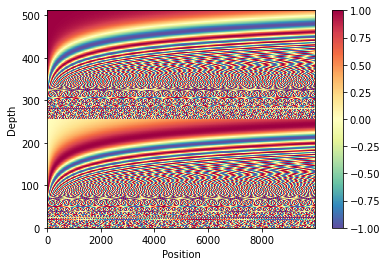

In [29]:
pos_encoding = positional_encoding(length=VOCAB_SIZE, depth=D_MODEL)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='Spectral_r')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

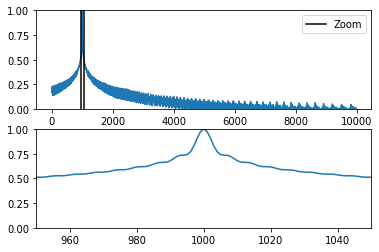

In [30]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])
plt.show()

In [31]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [32]:
embed_pt = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)
embed_en = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)
en_emb._keras_mask[0]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

#### The base attention layer

In [33]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### The cross attention layer

In [34]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [35]:
sample_ca = CrossAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 20, 512)
(64, 20, 512)
(64, 20, 512)


#### The global self attention layer

In [36]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [37]:
sample_gsa = GlobalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### The causal self attention layer

In [38]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [39]:
sample_csa = CausalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 20, 512)
(64, 20, 512)


In [40]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

#### The feed forward network

In [41]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [42]:
sample_ffn = FeedForward(D_MODEL, DFF)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### The encoder layer

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [44]:
sample_encoder_layer = EncoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 20, 512)
(64, 20, 512)


In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1, **kwargs):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [46]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 20)
(64, 20, 512)


#### The decoder layer

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [48]:
sample_decoder_layer = DecoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 20, 512)
(64, 20, 512)
(64, 20, 512)


In [49]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [50]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 20)
(64, 20, 512)
(64, 20, 512)


#### The Transformer

In [51]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [52]:
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT)

In [53]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 20)
(64, 20)
(64, 20, 9980)


In [54]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 4, 20, 20)


In [55]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  14041600  
                                                                 
 decoder_1 (Decoder)         multiple                  22445568  
                                                                 
 dense_22 (Dense)            multiple                  5119740   
                                                                 
Total params: 41,606,908
Trainable params: 41,606,908
Non-trainable params: 0
_________________________________________________________________


### Training

#### Set up the optimizer

In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [57]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

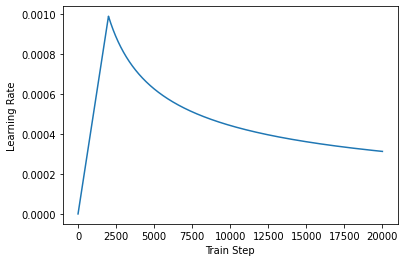

In [58]:
plt.plot(learning_rate(tf.range(20000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [59]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Train the model

In [60]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [61]:
%%time
t_tistory = transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/10
729/729 [==============================] - 131s 154ms/step - loss: 6.1837 - masked_accuracy: 0.2189 - val_loss: 4.8355 - val_masked_accuracy: 0.3084
Epoch 2/10
729/729 [==============================] - 92s 126ms/step - loss: 4.3285 - masked_accuracy: 0.3398 - val_loss: 4.0853 - val_masked_accuracy: 0.3545
Epoch 3/10
729/729 [==============================] - 89s 122ms/step - loss: 3.7523 - masked_accuracy: 0.3684 - val_loss: 3.9095 - val_masked_accuracy: 0.3636
Epoch 4/10
729/729 [==============================] - 88s 121ms/step - loss: 3.2687 - masked_accuracy: 0.3991 - val_loss: 3.7002 - val_masked_accuracy: 0.3844
Epoch 5/10
729/729 [==============================] - 91s 124ms/step - loss: 2.7156 - masked_accuracy: 0.4534 - val_loss: 3.6472 - val_masked_accuracy: 0.3925
Epoch 6/10
729/729 [==============================] - 88s 120ms/step - loss: 2.2846 - masked_accuracy: 0.5091 - val_loss: 3.6734 - val_masked_accuracy: 0.4024
Epoch 7/10
729/729 [=========================

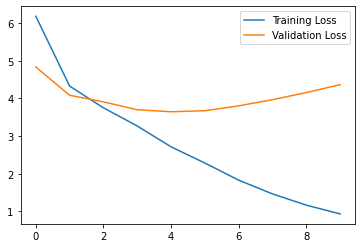

In [62]:
plt.plot(t_tistory.history["loss"], label="Training Loss")
plt.plot(t_tistory.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [63]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = transformer(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('질문 : "{}"'.format(sentence))
  print('답변 : "{}"'.format(predicted_sentence))

  return predicted_sentence

def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

### Test Chat

In [64]:
%%time
output = predict('취업하기 위해서 열심히 준비하고 있지만, 직장을 구하지 못할까봐 걱정되')

질문 : "취업하기 위해서 열심히 준비하고 있지만, 직장을 구하지 못할까봐 걱정되"
답변 : "걱정이 많으시겠어요 .  미래에 대한 불안이 크면 어떻게 하면 좋을까요 ?"
CPU times: user 1.8 s, sys: 18 ms, total: 1.82 s
Wall time: 2.1 s


In [65]:
%%time
output = predict('딸이 나에게 선물을 줬어. 그래서 너무 기뻐')

질문 : "딸이 나에게 선물을 줬어. 그래서 너무 기뻐"
답변 : "따님분이 선물을 주셨군요 .  정말 행복하시겠어요 ."
CPU times: user 938 ms, sys: 16.2 ms, total: 954 ms
Wall time: 969 ms


In [66]:
%%time
output = predict('너는 누구니?')

질문 : "너는 누구니?"
답변 : "저는 이연준님이 만든 챗봇이에요"
CPU times: user 1.36 s, sys: 18.3 ms, total: 1.38 s
Wall time: 1.34 s


In [67]:
%%time
output = predict('아무리 생각해도 너는 멍청한 것 같아')

질문 : "아무리 생각해도 너는 멍청한 것 같아"
답변 : "무엇 때문에 말에 상처받아 할까요 ?"
CPU times: user 687 ms, sys: 8.7 ms, total: 696 ms
Wall time: 675 ms
